In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

(diagnostic_for_classification)=
# Diagnostics for Classifications

## Objectives

+ To assess the qualtity of a classification model

## High melting explosives sensitivity
Let's repeat what we did for the HMX example, but after splitting the dataset into training and validation subsets.
We will be making predictions on the validation subset.

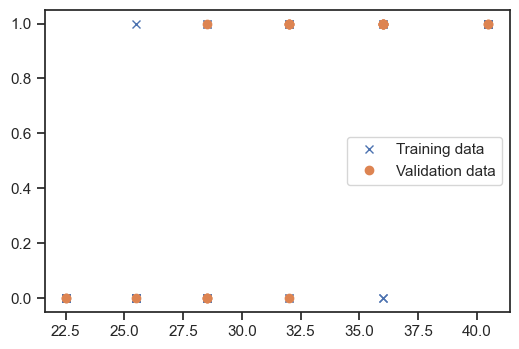

In [2]:
# TODO: Change url
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/hmx_data.csv'
download(url)

import pandas as pd
data = pd.read_csv('hmx_data.csv')
x = data['Height'].values
label_coding = {'E': 1, 'N': 0}
y = np.array([label_coding[r] for r in data['Result']])
data['y'] = y

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33)

num_obs = x.shape[0]

fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
plt.legend(loc='best');

Fit the model like before:

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Design matrix
poly = PolynomialFeatures(2)
Phi = poly.fit_transform(x[:, None])

# Fit
model = LogisticRegression(
    penalty='none',
    fit_intercept=False
).fit(Phi, y)

Predict on validation:

In [4]:
Phi_valid = poly.fit_transform(x_valid[:, None])
predictions = model.predict_proba(Phi_valid)

Decide:

In [5]:
cost_matrix = np.array(
    [
        [0.0, 1.0],
        [1.0, 0.0]
    ]
)

exp_cost = np.einsum('ij,ki->kj', cost_matrix, predictions)
y_pred = np.argmin(exp_cost, axis=1)

print('x\tCost of 0\tCost of 1\tTrue label\tChoice')
print('-' * 80)
for i in range(x_valid.shape[0]):
    exp_c = exp_cost[i]
    line = f'{x_valid[i]:1.2f}\t{exp_c[0]:1.2f}'
    tmp = f'\t\t{exp_c[1]:1.2f}'
    correct_choice = True
    if exp_c[0] < exp_c[1]:
        line += '*'
        if y_valid[i] == 1:
            correct_choice = False
    else:
        tmp += '*'
        if y_valid[i] == 0:
            correct_choice = False
    line += tmp + f'\t\t{y_valid[i]}'
    if correct_choice:
        line += '\t\tCORRECT'
    else:
        line += '\t\tWRONG'
    print(line)

x	Cost of 0	Cost of 1	True label	Choice
--------------------------------------------------------------------------------
40.50	0.99		0.01*		1		CORRECT
28.50	0.25*		0.75		0		CORRECT
36.00	0.90		0.10*		1		CORRECT
22.50	0.07*		0.93		0		CORRECT
25.50	0.12*		0.88		0		CORRECT
36.00	0.90		0.10*		1		CORRECT
28.50	0.25*		0.75		0		CORRECT
32.00	0.57		0.43*		0		WRONG
36.00	0.90		0.10*		1		CORRECT
22.50	0.07*		0.93		0		CORRECT
32.00	0.57		0.43*		1		CORRECT
36.00	0.90		0.10*		1		CORRECT
40.50	0.99		0.01*		1		CORRECT
32.00	0.57		0.43*		1		CORRECT
32.00	0.57		0.43*		1		CORRECT
32.00	0.57		0.43*		1		CORRECT
36.00	0.90		0.10*		1		CORRECT
36.00	0.90		0.10*		1		CORRECT
28.50	0.25*		0.75		0		CORRECT
28.50	0.25*		0.75		1		WRONG


First, let's calculate the accuracy score:

In [6]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_valid, y_pred)

print(f'HMX Accuracy = {acc * 100:1.2f} %')

HMX Accuracy = 90.00 %


Not bad. But let's also look at the balanced accuracy score:

In [7]:
from sklearn.metrics import balanced_accuracy_score

bacc = balanced_accuracy_score(y_valid, y_pred)

print(f'HMX balanced accuracy = {bacc * 100:1.2f} %')

HMX balanced accuracy = 89.01 %


Now, let's look at the confusion matrix:

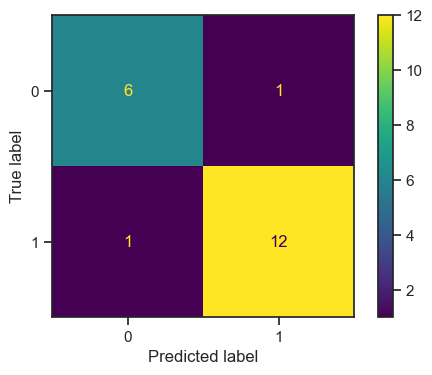

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_valid,
    y_pred,
    labels=model.classes_
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model.classes_
)
disp.plot();

### Questions

+ Repeat the analysis above with a higher degree polynomial, say 5. Is the result better or worse? Why?